In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [8]:
# doc

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [12]:
# len(doc)

3395237

In [3]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('total number of loaded images: %d ' % len(descriptions))

total number of loaded images: 8092 


In [21]:
# descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [18]:
# x='1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'
# x.split()[0].split('.')[0]

'1000268201_693b08cb0e'

In [26]:
# descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [4]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [29]:
# descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with pi

In [5]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [31]:
# vocabulary

{'hardwood',
 'parasailing',
 'recliner',
 'backward',
 'granite',
 'armour',
 'man',
 'party',
 'restaurants',
 'colliding',
 'strange',
 'calf',
 'receive',
 'buggys',
 'pointer',
 'identification',
 'yellowgold',
 'candles',
 'medieval',
 'nine',
 'pinwheel',
 'snowing',
 'megaphone',
 'milling',
 'cobbled',
 'yorkshire',
 'blower',
 'sandcastles',
 'sofa',
 'diverse',
 'snowdrift',
 'wings',
 'disrupt',
 'completes',
 'boundary',
 'raining',
 'just',
 'dribbling',
 'challenge',
 'emerald',
 'members',
 'nitro',
 'spots',
 'sheltered',
 'olympics',
 'flat',
 'salvar',
 'dueling',
 'sumo',
 'bears',
 'meat',
 'tones',
 'rollerblades',
 'downpour',
 'keyboard',
 'art',
 'streetpole',
 'childern',
 'bigg',
 'hankerchief',
 'banister',
 'seated',
 'frowning',
 'prize',
 'poised',
 'zooming',
 'foggyday',
 'poorly',
 'pan',
 'diego',
 'liked',
 'pamphlets',
 'knotted',
 'air',
 'condoms',
 'diry',
 'interested',
 'wanting',
 'youngsters',
 'coats',
 'las',
 'halfcompleted',
 'speeds',
 '

In [6]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [7]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
    # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [38]:
# train

{'451081733_40218cec31',
 '250406927_a5028a31d4',
 '3171066023_ec60ba30f3',
 '407008823_bdd7fc6ed5',
 '3109780402_dbae082dc5',
 '3454315016_f1e30d4676',
 '512031915_0dd03dcdf9',
 '2782480767_064c95eff2',
 '3532412342_e0a004b404',
 '3126724531_f483e1b92a',
 '3046916429_8e2570b613',
 '2972929655_04233b5489',
 '417966898_a04f9b5349',
 '3639845565_be547c38ba',
 '2330062180_355ccbceb5',
 '861608773_bdafd5c996',
 '2783620390_02c166c733',
 '2507182524_7e83c6de82',
 '3304030264_da3dd18c7b',
 '2405599120_ec5f32af6f',
 '437054333_5c2761b8cd',
 '2932519416_11f23b6297',
 '367925122_335ed279a8',
 '3350671534_2a5d45a961',
 '2282895743_f803f1cf01',
 '3612249030_e2829ffa31',
 '2528547068_7d37479b9b',
 '1818403842_553a2a392c',
 '3126773489_7ae425af17',
 '3713922357_e0a013fb97',
 '3667822570_d39850e217',
 '3705976184_53ae07e898',
 '3672940355_47f30e2b28',
 '369360998_ba56fb436f',
 '556568556_bc5124dc8e',
 '2851304910_b5721199bc',
 '2380765956_6313d8cae3',
 '2766726291_b83eb5d315',
 '517102724_a0f3069156

In [9]:
# Below path contains all the images
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [41]:
# img

['Flickr8k_Dataset/Flicker8k_Dataset/3558438174_d8f41438a4.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2295447147_458cfea65a.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3639428663_dae5e8146e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3136043366_b3f8607a0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/160805827_5e6646b753.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2868575889_2c030aa8ae.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/745966757_6d16dfad8f.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3081734118_6f2090215c.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3480051754_18e5802558.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/275516348_cbccebc125.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2259203920_6b93b721ce.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2955673642_4279b32097.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1713248099_d860df4e10.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1124448967_2221af8dc5.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3251088971_f4471048e3.jpg',
 'Flickr8k_Dataset/Flicker8k

In [42]:
# len(img)

8097

In [10]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [46]:
# train_img

['Flickr8k_Dataset/Flicker8k_Dataset/3558438174_d8f41438a4.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2295447147_458cfea65a.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3639428663_dae5e8146e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3136043366_b3f8607a0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/160805827_5e6646b753.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/745966757_6d16dfad8f.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3081734118_6f2090215c.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/275516348_cbccebc125.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2259203920_6b93b721ce.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2955673642_4279b32097.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1713248099_d860df4e10.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1124448967_2221af8dc5.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3251088971_f4471048e3.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/582788646_dc40748639.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2195620255_6693479734.jpg',
 'Flickr8k_Dataset/Flicker8k_

In [48]:
# len(train_img)

6000

In [11]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [52]:
# len(test_img)
# test_img

['Flickr8k_Dataset/Flicker8k_Dataset/2868575889_2c030aa8ae.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3480051754_18e5802558.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3143155555_32b6d24f34.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3497224764_6e17544e0d.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3571147934_d1c8af1d6e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2718024196_3ff660416a.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2693425189_47740c22ed.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2358554995_54ed3baa83.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3564312955_716e86c48b.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1167669558_87a8a467d6.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/279728508_6bd7281f3c.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2666179615_f05a9d8331.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/311146855_0b65fdb169.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3490736665_38710f4b91.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3745451546_fc8ec70cbd.jpg',
 'Flickr8k_Dataset/Flicker8

In [12]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [56]:
# train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [13]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [14]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 1s 0us/step


In [62]:
type(model)

keras.engine.training.Model

In [36]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [65]:
# Model(model.input,model.)

In [70]:
# len(model.layers)

313

In [71]:
# model.layers

In [74]:
# model.layers[-2].output

<tf.Tensor 'avg_pool/Mean:0' shape=(?, 2048) dtype=float32>

In [75]:
# model.input

<tf.Tensor 'input_1:0' shape=(?, 299, 299, 3) dtype=float32>

In [76]:
# model_new.layers

In [37]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [78]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 421.5482563972473


In [81]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [26]:
encoding_train = load(open('encoded_train_images.pkl', 'rb'))

In [31]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.2MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
from tqdm import tqdm

In [38]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

100%|██████████| 1006/1006 [00:57<00:00, 23.12it/s]

Time taken in seconds = 57.8322594165802


In [40]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [41]:
encoding_test = load(open('encoded_test_images.pkl', 'rb'))

In [16]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [17]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [18]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [19]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [20]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [21]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [22]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [23]:
# Load Glove vectors
glove_dir = 'glove/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [24]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [42]:
embedding_matrix.shape

(1652, 200)

In [43]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [45]:
model.layers[2]

In [46]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [122]:
# epochs = 10
# number_pics_per_batch = 128
# steps = len(train_descriptions)//number_pics_per_batch

In [123]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('model1/model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
46/46 [==============================] - 45s 983ms/step - loss: 5.5278 - acc: 0.1187
Epoch 1/1
46/46 [==============================] - 39s 849ms/step - loss: 4.6963 - acc: 0.1922
Epoch 1/1
46/46 [==============================] - 39s 851ms/step - loss: 4.2065 - acc: 0.2295
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 3.9088 - acc: 0.2508
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 3.7133 - acc: 0.2660
Epoch 1/1
46/46 [==============================] - 39s 851ms/step - loss: 3.5736 - acc: 0.2786
Epoch 1/1
46/46 [==============================] - 39s 849ms/step - loss: 3.4621 - acc: 0.2887
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 3.3746 - acc: 0.2975
Epoch 1/1
46/46 [==============================] - 39s 850ms/step - loss: 3.3021 - acc: 0.3036
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 3.2406 - acc: 0.3102


In [124]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('model1/model_' + str(i) + '.h5')

Epoch 1/1
46/46 [==============================] - 39s 850ms/step - loss: 3.1843 - acc: 0.3156
Epoch 1/1
46/46 [==============================] - 39s 851ms/step - loss: 3.1318 - acc: 0.3218
Epoch 1/1
46/46 [==============================] - 39s 853ms/step - loss: 3.0857 - acc: 0.3269
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 3.0449 - acc: 0.3314
Epoch 1/1
46/46 [==============================] - 39s 850ms/step - loss: 3.0068 - acc: 0.3347
Epoch 1/1
46/46 [==============================] - 39s 851ms/step - loss: 2.9722 - acc: 0.3386
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 2.9400 - acc: 0.3420
Epoch 1/1
46/46 [==============================] - 39s 853ms/step - loss: 2.9093 - acc: 0.3462
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 2.8817 - acc: 0.3486
Epoch 1/1
46/46 [==============================] - 39s 852ms/step - loss: 2.8590 - acc: 0.3506


In [139]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [140]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.7208 - acc: 0.3598
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.6409 - acc: 0.3697
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.5965 - acc: 0.3758
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 2.5611 - acc: 0.3799
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.5386 - acc: 0.3828
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.5141 - acc: 0.3863
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 2.4937 - acc: 0.3883
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.4751 - acc: 0.3915
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 2.4591 - acc: 0.3937
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.4445 - acc: 0.3949


In [142]:
model.save_weights('model1/new1.h5')

In [215]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [216]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
2000/2000 [==============================] - 171s 86ms/step - loss: 2.5451 - acc: 0.3785
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.5113 - acc: 0.3837
Epoch 1/1
2000/2000 [==============================] - 169s 84ms/step - loss: 2.4970 - acc: 0.3852
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.4859 - acc: 0.3869
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.4727 - acc: 0.3882
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.4679 - acc: 0.3887
Epoch 1/1
2000/2000 [==============================] - 171s 85ms/step - loss: 2.4556 - acc: 0.3908
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.4479 - acc: 0.3922
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.4434 - acc: 0.3929
Epoch 1/1
2000/2000 [==============================] - 169s 85ms/step - loss: 2.4373 - acc: 0.3937


In [236]:
model.optimizer.lr = 0.0001
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.4295 - acc: 0.3959


In [51]:
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [52]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 167s 84ms/step - loss: 2.5019 - acc: 0.3871
Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.4654 - acc: 0.3899
Epoch 1/1
2000/2000 [==============================] - 162s 81ms/step - loss: 2.4581 - acc: 0.3912
Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.4460 - acc: 0.3918
Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.4385 - acc: 0.3932
Epoch 1/1
2000/2000 [==============================] - 163s 81ms/step - loss: 2.4329 - acc: 0.3943
Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.4286 - acc: 0.3945
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.4189 - acc: 0.3965
Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.4158 - acc: 0.3962
Epoch 1/1
2000/2000 [==============================] - 163s 8

In [53]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [54]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 100s 100ms/step - loss: 2.2985 - acc: 0.4148
Epoch 1/1
1000/1000 [==============================] - 101s 101ms/step - loss: 2.2743 - acc: 0.4193
Epoch 1/1
1000/1000 [==============================] - 101s 101ms/step - loss: 2.2732 - acc: 0.4185
Epoch 1/1
1000/1000 [==============================] - 101s 101ms/step - loss: 2.2675 - acc: 0.4197
Epoch 1/1
1000/1000 [==============================] - 101s 101ms/step - loss: 2.2634 - acc: 0.4206
Epoch 1/1
1000/1000 [==============================] - 101s 101ms/step - loss: 2.2519 - acc: 0.4218
Epoch 1/1
1000/1000 [==============================] - 97s 97ms/step - loss: 2.2520 - acc: 0.4215
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.2422 - acc: 0.4232
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.2425 - acc: 0.4237
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.2331 - acc: 0.4245


In [74]:
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [75]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.3436 - acc: 0.4054
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.3275 - acc: 0.4091
Epoch 1/1
2000/2000 [==============================] - 162s 81ms/step - loss: 2.3260 - acc: 0.4089
Epoch 1/1
2000/2000 [==============================] - 163s 81ms/step - loss: 2.3261 - acc: 0.4088
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.3231 - acc: 0.4104
Epoch 1/1
2000/2000 [==============================] - 178s 89ms/step - loss: 2.3243 - acc: 0.4092
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.3248 - acc: 0.4087
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.3240 - acc: 0.4090
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 2.3205 - acc: 0.4095
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 2.3219 - acc: 0.4098
Epoch 1/1


In [94]:
model.optimizer.lr = 0.0001
epochs = 1
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [95]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 2.2062 - acc: 0.4293


In [93]:
model.optimizer.lr = 0.0001
epochs = 5
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [238]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 2.4113 - acc: 0.3994
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.4017 - acc: 0.4016
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 2.3892 - acc: 0.4031
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 2.3800 - acc: 0.4037
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.3708 - acc: 0.4042


In [221]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [96]:
model.save_weights('model1/new1.h5')

In [97]:
model.load_weights('model1/new1.h5')

In [222]:
import pickle

In [217]:
# encoding_test = load(open('encoded_test_images.pkl', 'rb'))

In [98]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

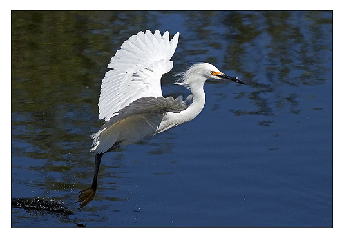

Caption: white crane landing over the water


In [99]:
z=33
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

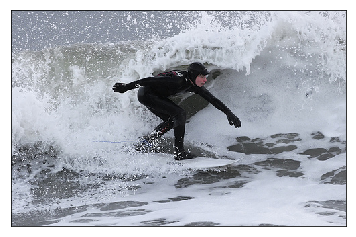

Caption: two surfers catch wave


In [100]:
z=323
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

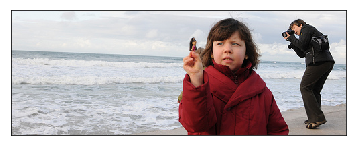

Caption: two girls stand on the shore looking at the water


In [101]:
z=339
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

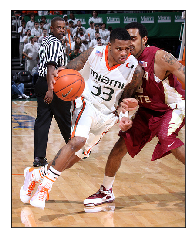

Caption: boy in white shorts and white shorts plays basketball


In [102]:
z=1000
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

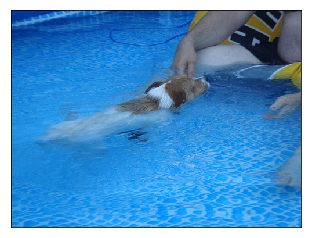

Caption: dog is jumping into pool


In [103]:
z=999
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

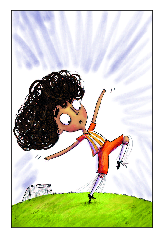

Caption: man in black shorts and black pants is climbing rock wall


In [104]:
pic = 'pleaseMe.jpg' 
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

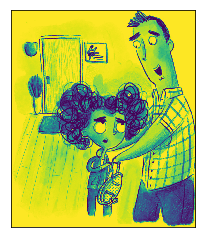

Caption: man in white shirt and cast is in front of group of people


In [105]:
pic = 'hello1.jpg' 
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

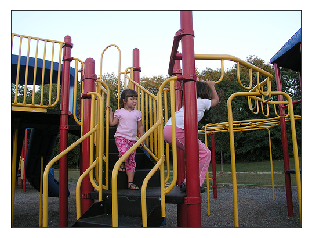

Caption: two children are playing on slide


In [106]:
z=86
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

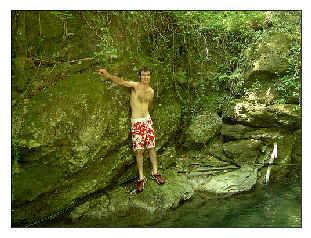

Caption: two men are climbing rock face upside down


In [107]:
z=129
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

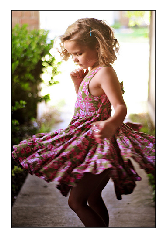

Caption: woman in heels and flip flops is walking on the street


In [108]:
z=136
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

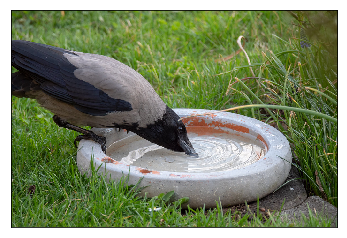

Caption: dog is running in the grass


In [109]:
pic = 'crow.jpg' 
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

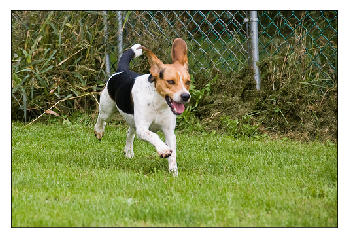

Caption: two dogs are running through field


In [110]:
z=15
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

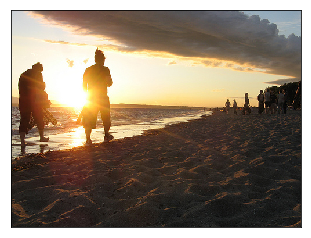

Caption: three people are walking on the beach


In [111]:
z=16
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

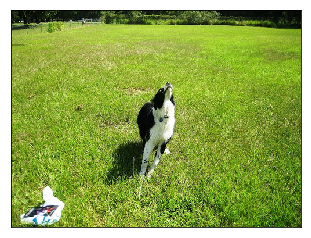

Caption: dog is running through field


In [112]:
z=25
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

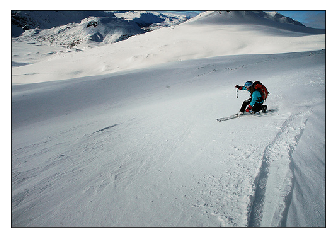

Caption: skier is skiing down snowy hill


In [113]:
z=26
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

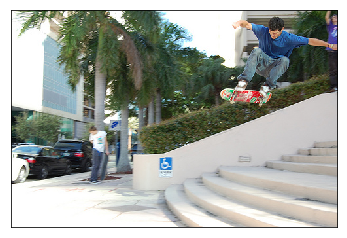

Caption: boy in red shirt is doing skateboard trick on the sidewalk


In [114]:
z=400
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))

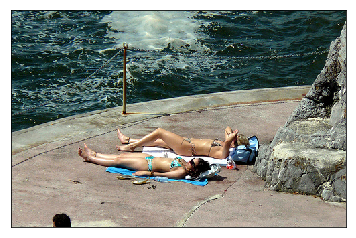

Caption: two children floating on the back of the pool


In [121]:
z=407
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])
cur_axes.axes.get_yaxis().set_ticklabels([])
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.imshow(x)
plt.show()
print("Caption:",greedySearch(image))